# A Transfer Learning and Optimized CNN Based Intrusion Detection System using UNSW-NB15
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 1: Data pre-processing**  
Procedures:  
&nbsp; 1): Read the dataset  
&nbsp; 2): Transform the tabular data into images  
&nbsp; 3): Display the transformed images  
&nbsp; 4): Split the training and test set  

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

## Read the Car-Hacking/CAN-Intrusion dataset
The complete Car-Hacking dataset is publicly available at: https://ocslab.hksecurity.net/Datasets/CAN-intrusion-dataset  
In this repository, due to the file size limit of GitHub, we use the 5% subset.

In [2]:
#Read dataset
df=pd.read_csv('data/UNSW-NB15.csv')

In [3]:
df

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390.0,149.171.126.6,53.0,udp,CON,0.001055,132,164,31,...,0.0,3,7,1,3,1,1,1,Normal,0
1,59.166.0.0,33661.0,149.171.126.9,1024.0,udp,CON,0.036133,528,304,31,...,0.0,2,4,2,3,1,1,2,Normal,0
2,59.166.0.6,1464.0,149.171.126.7,53.0,udp,CON,0.001119,146,178,31,...,0.0,12,8,1,2,2,1,1,Normal,0
3,59.166.0.5,3593.0,149.171.126.5,53.0,udp,CON,0.001209,132,164,31,...,0.0,6,9,1,1,1,1,1,Normal,0
4,59.166.0.3,49664.0,149.171.126.0,53.0,udp,CON,0.001169,146,178,31,...,0.0,7,9,1,1,1,1,1,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,59.166.0.5,33094.0,149.171.126.7,43433.0,tcp,FIN,0.087306,320,1828,31,...,-1.0,1,2,3,3,1,1,3,Normal,0
2539735,59.166.0.7,20848.0,149.171.126.4,21.0,tcp,CON,0.365058,456,346,31,...,2.0,2,2,2,2,2,2,2,Normal,0
2539736,59.166.0.3,21511.0,149.171.126.9,21.0,tcp,CON,6.335154,1802,2088,31,...,2.0,2,2,4,2,2,2,2,Normal,0
2539737,59.166.0.9,35433.0,149.171.126.0,80.0,tcp,CON,2.200934,3498,166054,31,...,-1.0,1,1,2,4,2,2,2,Normal,0


In [4]:
df['attack_cat'].value_counts()

Normal            2218456
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             2329
Shellcode            1511
Worms                 174
Name: attack_cat, dtype: int64

In [5]:
# # Read the downloaded training set
# df_training = pd.read_csv('data/achieve/UNSW_NB15_training-set.csv', index_col='id')
# # Get feature set
# features = df_training.columns.to_list()
# # Adjustments
# # Rename some feature names to match the complete dataset
# rename_dict = {
#     'smean': 'smeansz',
#     'dmean': 'dmeansz',
#     'response_body_len': 'res_bdy_len',
#     'sinpkt': 'sintpkt',
#     'dinpkt': 'dintpkt'
# }
# features = list(map(lambda x: rename_dict[x] if x in rename_dict else x, features))
# # Remove feature 'rate' since it is not in the dataset
# features.remove('rate')
# # Remove feature 'label' to match the original code of MTH-IDS_IoTJ
# features.remove('label')
# # Release Memory
# del df_training

# For convenience
features = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth',
 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login',
 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']

print(features)

['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']


In [6]:
# Only keep the influencing features
df = df[features]

### Data Sampling

In [7]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for col_name in df.dtypes[df.dtypes == 'object'].index.drop(['attack_cat']):
      df[col_name] = labelencoder.fit_transform(df[col_name])
df.insert(loc=len(df.columns), column='tmp_label', value=labelencoder.fit_transform(df['attack_cat']))

In [8]:
df['tmp_label'].value_counts()

6    2218456
5     215481
3      44525
4      24246
2      16353
7      13987
0       2677
1       2329
8       1511
9        174
Name: tmp_label, dtype: int64

In [9]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['tmp_label']==0)|(df['tmp_label']==1)|(df['tmp_label']==9)|(df['tmp_label']==2)|(df['tmp_label']==10)]
df_major = df.drop(df_minor.index)

In [10]:
X = df_major.drop(['attack_cat', 'tmp_label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [11]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [12]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [13]:
df_major['klabel'].value_counts()

716    18486
830    16442
477    16065
16     14362
631    11899
       ...  
5          5
217        4
948        4
84         2
632        2
Name: klabel, Length: 1000, dtype: int64

In [14]:
cols = list(df_major)
cols.insert(42, cols.pop(cols.index('tmp_label')))
df_major = df_major.loc[:, cols]

In [15]:
df_major

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,tmp_label,klabel
0,0.001055,119,2,2,2,2,132,164,31,29,...,1,0.0,0.0,0.0,3,7,0,Normal,6,538
1,0.036133,119,0,2,4,4,528,304,31,29,...,2,0.0,0.0,0.0,3,4,0,Normal,6,423
2,0.001119,119,2,2,2,2,146,178,31,29,...,1,0.0,0.0,0.0,2,8,0,Normal,6,609
3,0.001209,119,2,2,2,2,132,164,31,29,...,1,0.0,0.0,0.0,1,9,0,Normal,6,202
4,0.001169,119,2,2,2,2,146,178,31,29,...,1,0.0,0.0,0.0,1,9,0,Normal,6,980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,0.087306,113,4,5,6,8,320,1828,31,29,...,3,-1.0,-1.0,-1.0,3,2,0,Normal,6,42
2539735,0.365058,113,3,2,8,6,456,346,31,29,...,2,2.0,2.0,-1.0,2,2,0,Normal,6,756
2539736,6.335154,113,3,2,32,30,1802,2088,31,29,...,2,2.0,2.0,-1.0,2,2,0,Normal,6,121
2539737,2.200934,113,5,2,58,116,3498,166054,31,29,...,2,-1.0,-1.0,2.0,4,1,0,Normal,6,898


In [16]:
def typicalSampling(group):
    name = group.name
    frac = 0.25
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [17]:
result['attack_cat'].value_counts()

Normal            554657
Generic            53917
Exploits           11012
Fuzzers             6072
Reconnaissance      3514
Shellcode            375
Name: attack_cat, dtype: int64

In [18]:
result

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,tmp_label,klabel
1439261,0.590762,113,9,5,52,40,37180,3276,31,29,...,1,-1.0,-1.0,-1.0,5,1,0,Normal,6,0
2190188,0.224364,113,4,5,8,12,424,8824,31,29,...,5,-1.0,-1.0,-1.0,7,3,0,Normal,6,0
2365625,1.126046,113,5,5,12,18,1580,10168,31,29,...,1,-1.0,-1.0,1.0,1,1,0,Normal,6,0
977710,0.291612,113,4,5,8,12,424,8824,31,29,...,3,0.0,0.0,0.0,3,3,0,Normal,6,0
2130028,0.765817,113,0,5,16,18,1540,1644,31,29,...,5,-1.0,-1.0,-1.0,6,7,0,Normal,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641170,0.002947,119,0,2,4,4,528,304,31,29,...,1,-1.0,-1.0,-1.0,1,5,0,Normal,6,999
2517571,0.003625,119,0,2,4,4,544,304,31,29,...,3,-1.0,-1.0,-1.0,3,2,0,Normal,6,999
1010391,0.003056,119,0,2,4,4,536,304,31,29,...,3,0.0,0.0,0.0,8,19,0,Normal,6,999
2002683,0.003026,119,0,2,4,4,528,304,31,29,...,3,-1.0,-1.0,-1.0,2,3,0,Normal,6,999


In [19]:
result = result.drop(['tmp_label', 'klabel'],axis=1)
df = result.append(df_minor.drop(['tmp_label'], axis=1))

In [20]:
df.to_csv('./data/UNSW-NB15_sample_km.csv',index=0)

In [21]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df['attack_cat'].value_counts()

Normal            554657
Generic            53917
DoS                16353
Exploits           11012
Fuzzers             6072
Reconnaissance      3514
Analysis            2677
Backdoor            2329
Shellcode            375
Worms                174
Name: attack_cat, dtype: int64

### Feature Engineering

In [22]:
# df=pd.read_csv('./data/UNSW-NB15_sample_km.csv')

In [23]:
X = df.drop(['attack_cat'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [25]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [26]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [27]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [28]:
fs.append('attack_cat')
df = df[fs]
df

,sbytes,sload,smeansz,sttl,ct_state_ttl,dttl,dbytes,dmeansz,dur,dload,...,ct_dst_ltm,ct_srv_dst,ct_srv_src,sjit,djit,service,sloss,ct_src_ltm,swin,attack_cat
1439261,37180,4.938029e+05,715,31,0,29,3276,82,0.590762,43266.152340,...,4,1,1,954.468681,36.540422,9,18,5,255,Normal
2190188,424,1.322850e+04,53,31,0,29,8824,735,0.224364,288424.156300,...,3,3,3,2161.008772,1710.396978,4,1,7,255,Normal
2365625,1580,1.029443e+04,132,31,0,29,10168,565,1.126046,68231.671880,...,3,1,1,9722.540576,7829.475089,5,3,1,255,Normal
977710,424,1.017791e+04,53,31,0,29,8824,735,0.291612,221911.312500,...,6,3,3,2586.549075,2056.284653,4,1,3,255,Normal
2130028,1540,1.508454e+04,96,31,0,29,1644,91,0.765817,16223.197270,...,6,7,9,3454.105684,75.219445,0,4,6,255,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538953,2641,1.143383e+04,110,62,1,252,1802,82,1.770885,7774.643555,...,3,1,1,4499.958844,131.854219,9,8,1,255,DoS
2539040,86346,4.720171e+05,1079,62,1,252,2292,82,1.445151,12239.551760,...,1,1,1,1601.802014,64.033879,9,37,1,255,DoS
2539640,330718,1.117591e+06,1282,62,1,252,1816,43,2.358193,6014.774902,...,1,1,1,1017.836724,60.182246,0,126,1,255,DoS
2539721,269883,8.330169e+05,1298,62,3,252,1300,43,2.579405,3898.573486,...,2,1,2,1701.614470,138.857703,0,103,4,255,DoS


### SMOTE to solve class-imbalance

In [29]:
df['attack_cat'].value_counts()

Normal            554657
Generic            53917
DoS                16353
Exploits           11012
Fuzzers             6072
Reconnaissance      3514
Analysis            2677
Backdoor            2329
Shellcode            375
Worms                174
Name: attack_cat, dtype: int64

In [30]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={'Backdoor':4000, 'Worms':4000, 'Shellcode': 4000, 'Analysis': 4000, 'Reconnaissance': 4000})

In [31]:
x, y = smote.fit_sample(df.drop(['attack_cat'], axis=1), df['attack_cat'])

In [32]:
x.insert(loc=len(x.columns), column='attack_cat', value=y.values)
df = x

## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform to transform the original data samples into the scale of [0,255], representing pixel values
2. Generate images for each category (Normal, DoS, Fuzzy, Gear, RPM), each image consists of 27 data samples with 9 features. Thus, the size of each image is 9*9*3, length 9, width 9, and 3 color channels (RGB).

In [33]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [34]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

In [35]:
df.describe()

,sbytes,sload,smeansz,sttl,ct_state_ttl,dttl,dbytes,dmeansz,dur,dload,...,spkts,ct_dst_ltm,ct_srv_dst,ct_srv_src,sjit,djit,service,sloss,ct_src_ltm,swin
count,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,...,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000,662011.000000
mean,127.322921,127.559756,127.577741,127.271850,41.096705,121.359255,121.527814,121.354692,127.643478,121.538444,...,127.564562,124.303050,124.583703,124.707856,108.077688,110.367701,95.523132,104.828542,125.125531,147.525892
std,73.629926,73.512564,73.486958,57.137755,88.772780,67.507919,81.609673,81.630072,73.705656,81.698271,...,72.255204,78.297939,78.288908,77.729614,93.084087,91.720638,98.382091,94.898272,76.568164,125.912354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.303303,64.182316,66.111111,94.954955,0.000000,148.686186,60.750751,63.941441,64.069069,63.898277,...,44.924925,66.621622,57.049550,54.879880,0.000000,0.000000,0.000000,0.000000,55.645646,0.000000
50%,127.287287,127.445670,128.265766,94.954955,0.000000,148.686186,126.734234,122.650150,127.543460,127.248056,...,130.945946,111.674174,134.136637,129.542042,126.879856,127.660370,0.000000,123.798799,131.073574,255.000000
75%,190.165165,191.348537,202.034535,198.843844,0.000000,148.686186,191.142007,191.313814,191.610249,191.322536,...,193.611111,189.909910,193.738739,189.527027,190.782172,191.051090,165.405405,197.567568,189.144144,255.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


All features are in the same scale of [0,255]

### Generate images for each class

In [36]:
label_col = 'attack_cat'
dfs = [df[df[label_col]==tmp].drop([label_col],axis=1) for tmp in df[label_col].value_counts().index]
# df0=df[df[label_col]=='Normal'].drop([label_col],axis=1)
# df1=df[df[label_col]=='Generic'].drop([label_col],axis=1)
# df2=df[df[label_col]=='Exploits'].drop([label_col],axis=1)
# df3=df[df[label_col]=='Fuzzers'].drop([label_col],axis=1)
# df4=df[df[label_col]=='DoS'].drop([label_col],axis=1)
# df5=df[df[label_col]=='Reconnaissance'].drop([label_col],axis=1)
# df6=df[df[label_col]=='Analysis'].drop([label_col],axis=1)
# df7=df[df[label_col]=='Backdoor'].drop([label_col],axis=1)
# df8=df[df[label_col]=='Shellcode'].drop([label_col],axis=1)
# df9=df[df[label_col]=='Backdoors'].drop([label_col],axis=1)
# df10=df[df[label_col]=='Worms'].drop([label_col],axis=1)

In [37]:
# Generate 9*9 color images for every class
# Change the numbers 9 to the number of features n in your dataset if you use a different dataset, reshape(n,n,3)
# In this case the n = 40
n = len(df.columns)-1
for i in range(len(dfs)):
    tmp_df = dfs[i]
    count=0
    ims = []

    image_path = "train/{}/".format(i)
    os.makedirs(image_path)

    for i in range(0, len(tmp_df)):  
        count += 1
        if count<=n*3: 
            im=tmp_df.iloc[i].values
            ims=np.append(ims,im)
        else:
            ims=np.array(ims).reshape(n,n,3)
            array = np.array(ims, dtype=np.uint8)
            new_image = Image.fromarray(array)
            new_image.save(image_path+str(i)+'.png')
            count=0
            ims = []

### Display samples for each category

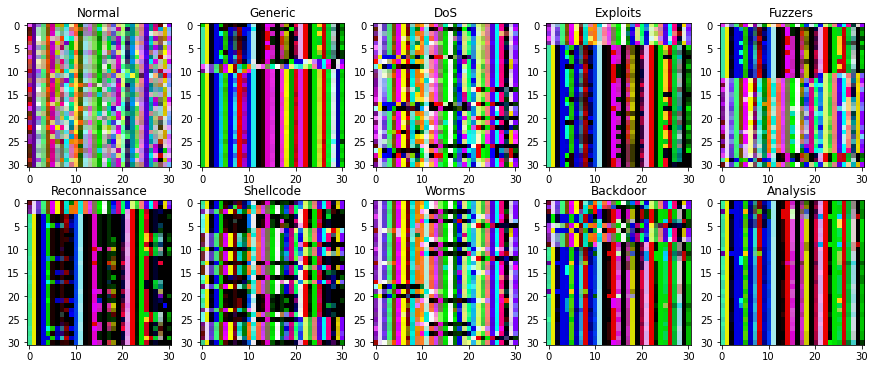

In [38]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
imgs = [Image.open('./train/{}/93.png'.format(i)) for i in range(len(dfs))]
# img1 = Image.open('./train/0/123.png')
# img2 = Image.open('./train/1/123.png')
# img3 = Image.open('./train/2/123.png')
# img4 = Image.open('./train/3/123.png')
# img5 = Image.open('./train/4/123.png')
# img6 = Image.open('./train/0/123.png')
# img7 = Image.open('./train/1/123.png')
# img8 = Image.open('./train/2/123.png')
# img9 = Image.open('./train/3/123.png')
# img10 = Image.open('./train/4/123.png')
# img11 = Image.open('./train/4/123.png')

titles = df[label_col].value_counts().index.to_list()

plt.figure(figsize=(15, 6)) 
for i in range(len(imgs)):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs[i])
    plt.title(titles[i])

# plt.subplot(1,5,1)
# plt.imshow(img1)
# plt.title("Normal")
# plt.subplot(1,5,2)
# plt.imshow(img2)
# plt.title("RPM Spoofing")
# plt.subplot(1,5,3)
# plt.imshow(img3)
# plt.title("Gear Spoofing")
# plt.subplot(1,5,4)
# plt.imshow(img4)
# plt.title("DoS Attack")
# plt.subplot(1,5,5)
# plt.imshow(img5)
# plt.title("Fuzzy Attack")

plt.show()  # display it

## Split the training and test set 

In [39]:
# Create folders to store images
Train_Dir='./train/'
Val_Dir='./test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

7037


In [40]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [41]:
# The size of test set
Numbers

1407

In [42]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [43]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [44]:
DATA_DIR_224='./train_224/'
get_224(folder='./train/',dstdir=DATA_DIR_224)

Finish resizing


In [45]:
DATA_DIR2_224='./test_224/'
get_224(folder='./test/',dstdir=DATA_DIR2_224)

Finish resizing
